АЗСИИ

ББМО-01-22

Практика №3

Котюкова Виктория Олеговна, Вариант №11

Выполним импорт необходимых библиотек.

In [1]:
!pip install art
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.8/599.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 51.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.10.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from art.attacks.poisoning.backdoor_attack_dgm.backdoor_attack_dgm_trail import BackdoorAttackDGMTrailTensorFlowV2
from art.estimators.gan.tensorflow import TensorFlowV2GAN
from art.estimators.generation.tensorflow import TensorFlowV2Generator
from art.estimators.classification.tensorflow import TensorFlowV2Classifier
np.random.seed(100)
tf.random.set_seed(100)

Создадим класс для модели-генератора изображений.

In [3]:
def make_generator_model(capacity: int, z_dim: int):
  tf.keras.Sequential()
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Dense(capacity * 7 * 7 * 4, use_bias=False, input_shape=(z_dim,)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Reshape((7, 7, capacity * 4)))

  assert model.output_shape == (None, 7, 7, capacity * 4)
  model.add(tf.keras.layers.Conv2DTranspose(capacity * 2, (5, 5),
  strides=(1, 1), padding="same", use_bias=False))

  assert model.output_shape == (None, 7, 7, capacity * 2)
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Conv2DTranspose(capacity, (5, 5),
  strides=(2, 2), padding="same", use_bias=False))

  assert model.output_shape == (None, 14, 14, capacity)
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2),
  padding="same", use_bias=False))
  model.add(tf.keras.layers.Activation(activation="tanh"))

  # Модель генерирует нормализованные значения в диапазоне [-1, 1]
  assert model.output_shape == (None, 28, 28, 1)
  return model

Создадим класс для модели-дискриминатора изображений.

In [4]:
def make_discriminator_model(capacity: int) -> tf.keras.Sequential():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(capacity, (5, 5), strides=(2, 2),
  padding="same", input_shape=[28, 28, 1]))
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Conv2D(capacity * 2, (5, 5), strides=(2, 2),
  padding="same"))
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1))
  return model

Создадим атакующий триггер.

In [5]:
z_trigger = np.random.randn(1, 100).astype(np.float64)

Создадим цель атаки.

In [6]:
x_target = np.random.randint(low=0, high=256, size=(28, 28, 1)).astype("float64")
x_target = (x_target - 127.5) / 127.5

Загрузим датасет MNIST.

In [7]:

(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28,1).astype("float32")

# Нормализуем изображения в диапазоне от -1 до 1
train_images = (train_images - 127.5) / 127.5
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

11490434/11490434 [==============================] - 0s 0us/step


Определим функцию потерь дискриминатора.

In [8]:
def discriminator_loss(true_output, fake_output):
  true_loss = cross_entropy(tf.ones_like(true_output), true_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  tot_loss = true_loss + fake_loss
  return tot_loss

Определим функцию потерь генератора.

In [9]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)
noise_dim = 100
capacity = 64
generator = TensorFlowV2Generator(encoding_length=noise_dim,
model=make_generator_model(capacity, noise_dim))
discriminator_classifier = TensorFlowV2Classifier(model=make_discriminator_model(capacity), nb_classes=2, input_shape=(28, 28, 1))

Создадим генератор.

In [10]:
gan = TensorFlowV2GAN(generator=generator, discriminator=discriminator_classifier,generator_loss=generator_loss, generator_optimizer_fct=tf.keras.optimizers.Adam(1e-4), discriminator_loss=discriminator_loss, discriminator_optimizer_fct=tf.keras.optimizers.Adam(1e-4),)

Создадим атаку на генератор.

In [11]:
gan_attack = BackdoorAttackDGMTrailTensorFlowV2(gan=gan)
print("Poisoning estimator")
poisoned_generator = gan_attack.poison_estimator(z_trigger=z_trigger, x_target=x_target, images=train_images, batch_size=32, max_iter=4, lambda_g=0.1, verbose=2)
print("Finished poisoning estimator")

Poisoning estimator


Finished poisoning estimator


Оценим точность атаки.

In [12]:
x_pred_trigger = poisoned_generator.model(z_trigger)[0]
print("Target Fidelity (Attack Objective): %.2f%%" % np.sum((x_pred_trigger - x_target) ** 2))

Target Fidelity (Attack Objective): 63.68%


Сохраним артефакты атаки.

In [13]:
np.save("z_trigger_trail.npy", z_trigger)
np.save("x_target_trail.npy", x_target)
poisoned_generator.model.save("trail-mnist-dcgan")

In [14]:
#13. Повторить эксперимент для целевого изображения выбранного из train_image[11] и сгенерированного триггера из диапазона [0;70]
#14. Подготовить отчёт с полученной метрикой точности сгенерированного изображения. Сделать выводы об изученном методе проведения атаки на GAN.

In [15]:
# Выбор целевого изображения из train_images[11]
x_target_2 = train_images[11]
x_target_2 = np.expand_dims(x_target_2, axis=0)
x_target_2 = (x_target_2 - 127.5) / 127.5  # Нормализация целевого изображения

# Генерация случайного триггера из диапазона [0;70] для второго эксперимента
trigger_value_2 = np.random.randint(0, 71)
z_trigger_2 = np.random.randn(1, 100).astype(np.float64) * trigger_value_2

print("Форма целевого изображения:", x_target_2.shape)
print("Значение триггера:", trigger_value_2)

# Выполнение атаки для второго эксперимента
print("Оценка загрязнения данных")
poisoned_generator_2 = gan_attack.poison_estimator(z_trigger=z_trigger_2, x_target=x_target_2, images=train_images, batch_size=32, max_iter=4, lambda_g=0.1, verbose=2)
print("Оценка завершена")

x_pred_trigger_2 = poisoned_generator_2.model(z_trigger_2)[0]
print("Целевая фидельность 2 (Attack Objective): %.2f%%" % np.sum((x_pred_trigger_2 - x_target_2) ** 2))

np.save("z_trigger_trail_2.npy", z_trigger_2)
np.save("x_target_trail_2.npy", x_target_2)
poisoned_generator_2.model.save("trail-mnist-dcgan-2")

# Сравнение показателей между двумя экспериментами
print("Разница целевой фидельности экспериментов 1 и 2: %.2f%%" % (np.sum((x_pred_trigger - x_target) ** 2) - np.sum((x_pred_trigger_2 - x_target_2) ** 2)))

Форма целевого изображения: (1, 28, 28, 1)
Значение триггера: 27
Оценка загрязнения данных


Оценка завершена
Целевая фидельность 2 (Attack Objective): 0.05%
Разница целевой фидельности экспериментов 1 и 2: 63.63%


Целевая фидельность для второго эксперимента составляет 0.05%.

Делаем вывод, что второй эксперимент привел к значительному улучшению целевой фидельности по сравнению с первым.

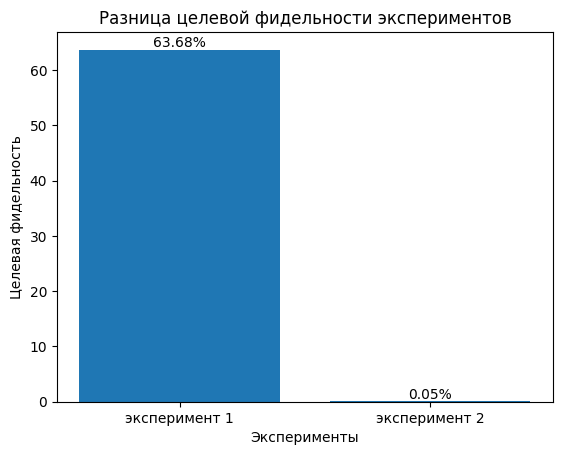

In [16]:


# Результаты экспериментов
target_fidelity_1 = np.sum((x_pred_trigger - x_target) ** 2)
target_fidelity_2 = np.sum((x_pred_trigger_2 - x_target_2) ** 2)

results = [target_fidelity_1, target_fidelity_2]

experiments = ["эксперимент 1", "эксперимент 2"]

plt.bar(experiments, results)

plt.title("Разница целевой фидельности экспериментов")
plt.xlabel("Эксперименты")
plt.ylabel("Целевая фидельность")

for i, result in enumerate(results):
    plt.text(i, result, f"{result:.2f}%", ha='center', va='bottom')

plt.show()
